# Анализ рекламных источников мобильной игры "Космические братья"

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.  
В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.  

Помимо основного датасета есть два датасета с информацией о рекламных активностях: источниках перехода и стоимости кликов.

**Целью исследования** является анализ поведения игроков в зависимости от рекламного источника перехода.  

**Этапы исследования:**

1. Обзор данных   
2. Предобработка данных   
3. Исследовательский анализ данных   
4. Проверка гипотез   
5. Вывод

<a name="h1"></a>
### 1. Обзор данных

#### Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

import numpy as np
import math as mth
import scipy.stats as stats
from scipy import stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Настройка

In [2]:
#отображение данных до двух знаков после запятой
pd.set_option('display.precision', 2)

#вывод всех значений ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Анализ файлов

In [3]:
game_actions = pd.read_csv('/datasets/game_actions.csv')
user_source = pd.read_csv('/datasets/user_source.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')

In [4]:
game_actions.head(3)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN


In [5]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


Представлены данные о 135 640 о событиях, совершенных в мобильной игре «Космические братья». Необходимо исправить тип данных в столбце `event_datetime`, проверить и устранить при необходимости пропуски в столбцах `building_type` и `project_type`

In [6]:
ad_costs.head(3)

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19


In [7]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


Датасет `ad_cost.csv` содержит информацию о дате клика, источнике трафика и стомости клика. Пропусков нет, однако необходимо исправить тип данных в столбце `day`

In [8]:
user_source.head(3)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama


In [9]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB


Доступна информация о рекламных источниках с которых пришли 13 576 пользователей, установивших приложение. Типы данных корректны, пропусков нет.

<a name="h2"></a>
### 2. Предобработка данных

- Проверим данные на наличие пропусков

In [10]:
ad_costs.isnull().sum()

source    0
day       0
cost      0
dtype: int64

In [11]:
user_source.isnull().sum()

user_id    0
source     0
dtype: int64

In [12]:
game_actions.isnull().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Проверим, не зависят ли пропуски от типа события (*'event'*)

In [13]:
game_actions['event'].value_counts()
game_actions[game_actions['building_type'].isnull()]['event'].value_counts()
game_actions[game_actions['project_type'].isnull()]['event'].value_counts()

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

finished_stage_1    5817
project             1866
Name: event, dtype: int64

building            127957
finished_stage_1      5817
Name: event, dtype: int64

**Результат**   
Пропущены данные обнаружены только в `game_actions['building_type']` и `game_actions['project_type']`. Пропуски логичны (зависят от типа события) и не требует устранения.

- Проверим, что в данных нет дубликатов

In [14]:
ad_costs.duplicated().sum()

0

In [15]:
user_source.duplicated().sum()

0

In [16]:
game_actions.duplicated().sum()

1

In [17]:
game_actions = game_actions.drop_duplicates()

**Результат**   
Удалили единственный дубликат в таблице `game_actions`.

- Исправим некорректные типы данных

In [18]:
ad_costs['day'] = pd.to_datetime(ad_costs['day']).dt.strftime('%Y-%m-%d')

In [19]:
ad_costs.dtypes

source     object
day        object
cost      float64
dtype: object

In [20]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

In [21]:
game_actions.dtypes

event_datetime    datetime64[ns]
event                     object
building_type             object
user_id                   object
project_type              object
dtype: object

**Результат**   
Типы данных исправлены.

<a name="h3"></a>
### 3. Исследовательский анализ данных

#### Анализ представленных датасетов

- Изучим основные статистически показатели по датасету `game_actions`

In [22]:
game_actions.describe().T

,count,unique,top,freq,first,last
event_datetime,135639,128790,2020-05-09 12:35:56,4,2020-05-04 00:00:01,2020-06-05 12:32:49
event,135639,3,building,127956,NaT,NaT
building_type,127956,3,spaceport,59325,NaT,NaT
user_id,135639,13576,d6aca06a-cd75-4cd8-b8cd-240a3c163884,22,NaT,NaT
project_type,1866,1,satellite_orbital_assembly,1866,NaT,NaT


In [23]:
print("Доля игроков, хотя бы раз совершивших событие типа 'building':", 
      len(game_actions[game_actions['event'] == 'building']['user_id'].unique()) / len(user_source) *100, "%")

Доля игроков, хотя бы раз совершивших событие типа 'building': 100.0 %


Представлены данные о событиях 13 576 пользователей в игре в период с 4 мая 2020 по 5 июня 2020. Самым распространенным событием  (в 94% случаев) является постройка одного из трех доступных типов объектов, чаще всего космодромов (46% всех построек). Исходя из полученных результатов можно сделать вывод, что либо по правилам игры пользователь должен построить хотя бы одно здание, либо постройка зданий приносит игрокам дополнительные бонусы, либо действуют оба фактора одновременно. Также можно отметить, что в игре, как минимум до первого уровня, доступен только один тип проекта - *satellite_orbital_assembly*.

Напишем функцию для создания графиков типа *barplot*. В качестве параметров будем указывать:  
    - датасет;
    - значения для оси Х;
    - значения для оси У;
    - название графика;
    - название оси Х;
    - название оси У;
    - количество значений Х.

In [24]:
def sns_barplot(data, x, y, title, xlabel, ylabel, colors):
    plt.figure(figsize=(16,7))
    ax = sns.barplot(x=x, y=y, data=data, palette=sns.color_palette("GnBu", colors), ci=None)

    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height):
            height = 0
        ax.text(p.get_x() + p.get_width()/2., height, '%d' % int(height), 
            fontsize=11, ha='center', va='bottom')
        
    plt.title(title, fontsize = 15, color='darkgreen')
    plt.xlabel(xlabel, fontsize = 12, fontweight=500, color='darkgreen')
    plt.ylabel(ylabel, fontsize = 12, fontweight=500, color='darkgreen');

- Изучим расходы на рекламу

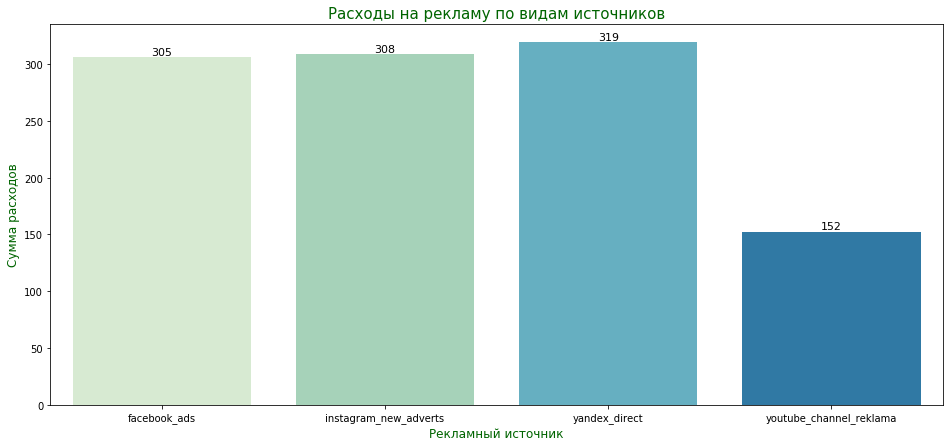

In [25]:
sns_barplot(ad_costs, 'source', 'cost', 'Расходы на рекламу по видам источников', 
            'Рекламный источник', 'Сумма расходов', 4)

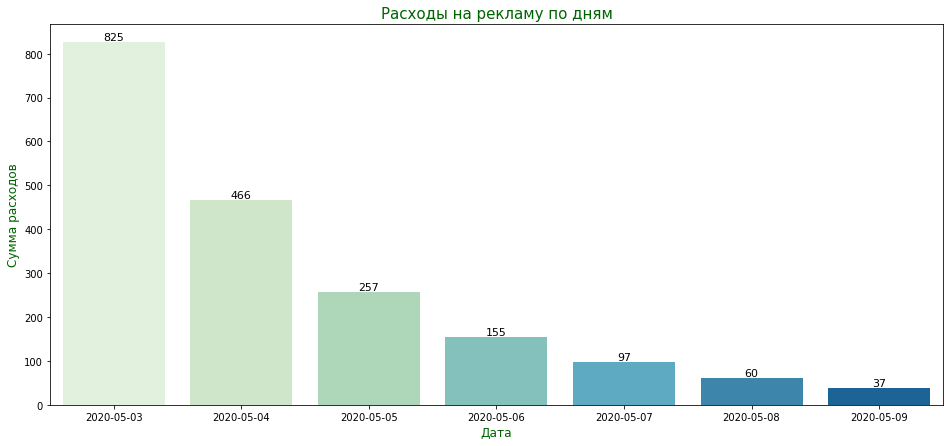

In [26]:
sns_barplot(ad_costs, 'day', 'cost', 'Расходы на рекламу по дням', 'Дата', 'Сумма расходов', 7)

На рекламу в Яндексе, Фейсбуке и Инстраграме расходуется примерно одинаковое количество денег, в то время как реклама на Ютубе обходится в 2 раза дешевле, чем любой другой рекламный источник. Больше всего денег было потрачено 3 мая. В дальнейшем расходы снижались примерно на 40-45% ежедневно относительно прошлого дня.  

- Определим эффективность работы рекламных источников

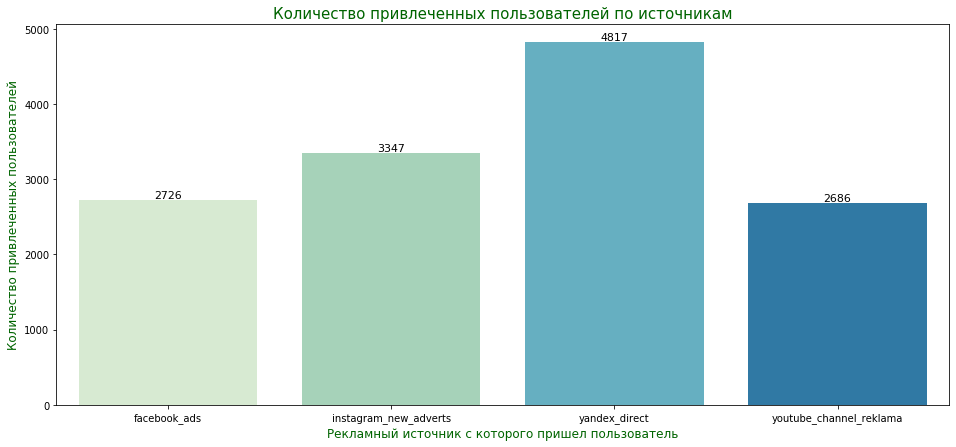

In [27]:
users_by_source = user_source.groupby('source')['user_id'].count().reset_index()
sns_barplot(users_by_source, 'source', 'user_id', 'Количество привлеченных пользователей по источникам', 
            'Рекламный источник с которого пришел пользователь', 'Количество привлеченных пользователей', 4)

Наиболее эффективно сработала реклама в Яндекс.Директ. Проверим стоимость привлечения одного игрока из каждого рекламного источника. Для этого:  
- рассчитаем общую величину расходов на рекламу по каждому источнику;
- объединим полученную информацию с датасетом `users_by_source`;
- рассчитаем показатель **САС** и отразим его на графике.

In [28]:
ad_by_soures = pd.DataFrame(ad_costs.groupby('source')['cost'].agg('sum')).reset_index()

In [29]:
CAC = pd.merge(ad_by_soures,users_by_source, on='source')

In [30]:
CAC['CAC'] = CAC['cost'] / CAC['user_id']

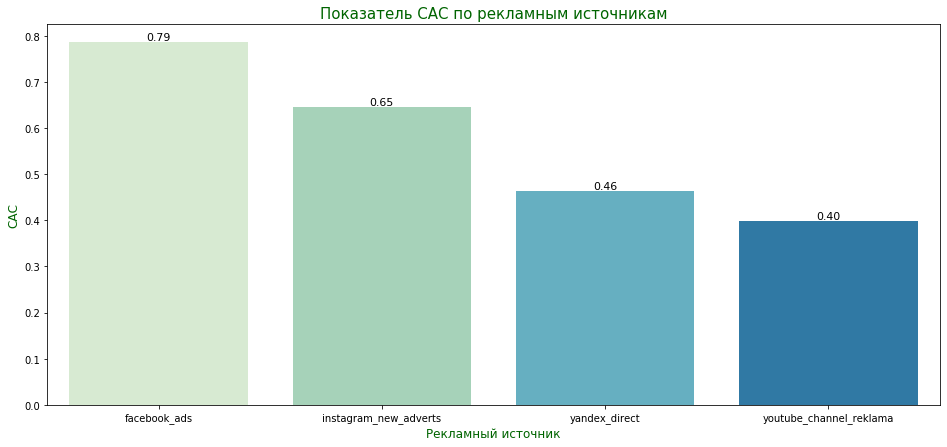

In [31]:
plt.figure(figsize=(16,7))
ax = sns.barplot(x='source', y='CAC', data=CAC, palette=sns.color_palette("GnBu", 4), ci=None)

for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        height = 0
    ax.text(p.get_x() + p.get_width()/2., height, "{:.2f}".format(height), 
            fontsize=11, ha='center', va='bottom')
        
plt.title('Показатель САС по рекламным источникам', fontsize = 15, color='darkgreen')
plt.xlabel('Рекламный источник', fontsize = 12, fontweight=500, color='darkgreen')
plt.ylabel('CAC', fontsize = 12, fontweight=500, color='darkgreen');

Реклама в Яндекс.Директ не только самая эффективная, но и достаточно выгодная, относительно других рекламных источников. Однако самым экономичным вариантом является Ютуб - он почти на 15% дешевле Яндекса и на 50% дешевле, чем Фейсбук.

#### Анализ взаимосвязи между рекламным источником и поведением игрока

На данном этапе мы рассмотрим поведение игроков и оценим:
- как источник перехода влияет на факт завершения первого уровня;
- как источник перехода влияет на выбор способа прохождения первого уровня.

Создадим один сводный датасет в котором будет содержаться следующая информация по каждому игроку:
    - идентификатор пользователя;
    - рекламный источник;
    - дата и время первого события;
    - дата и время завершения 1 уровня;
    - способ завершения первого уровня.

Создадим датасет с первыми действиями каждого игрока

In [32]:
first_action = game_actions.sort_values(by='event_datetime').drop_duplicates('user_id')
first_action = first_action[['user_id', 'event_datetime', 'event', 'building_type']]
first_action.columns = ['user_id', 'first_datetime','first_event', 'building_type']

In [33]:
first_action.describe().T

,count,unique,top,freq,first,last
user_id,13576,13576,403b194a-2a2a-4bfd-87ee-c8207d74bec8,1,NaT,NaT
first_datetime,13576,13304,2020-05-04 04:02:30,4,2020-05-04 00:00:01,2020-05-10 23:59:52
first_event,13576,1,building,13576,NaT,NaT
building_type,13576,1,assembly_shop,13576,NaT,NaT


Первое событие в игре у каждого игрока это строительство здания типа *assembly_shop*, что говорит нам о том, что данное действие является обязательным этапом в игре. Чтобы не загружать датасет, удалим из него столбцы `first_event` и `building_type`.

In [34]:
first_action = first_action.drop(['first_event', 'building_type'], axis=1)

Создадим датасет с датой и временем прохождения 1 уровня

In [35]:
lvl1 = game_actions[game_actions['event'] == 'finished_stage_1']
lvl1 = lvl1[['user_id', 'event_datetime']]
lvl1.columns = ['user_id', 'lvl1_datetime']

Создадим датасет с датой и временем завершения проекта

In [36]:
project = game_actions[game_actions['event'] == 'project']
project = project[['user_id', 'event']]
project.columns = ['user_id', 'event']

Добавим новые датасеты к уже существующему `user_source`

In [37]:
summary = user_source.merge(first_action, on='user_id', how='left')\
.merge(lvl1, on='user_id', how='left').merge(project, on='user_id', how='left')

Рассчитаем сколько времени потребовалось игрокам для достижения 1 уровня (в часах)

In [38]:
summary['lvl1_duration'] = (summary['lvl1_datetime'] - summary['first_datetime']).astype('timedelta64[h]')

Заполним пропуски в столбце `event`:
- значением *lvl0* для игроков, которые так и не достигли 1 уровня;
- значением *battle* для игроков, которые получили 1 уровень не завершая проект.

In [39]:
summary.loc[summary['lvl1_datetime'].isnull(), 'event'] = 'lvl0'
summary.loc[summary['event'].isnull(), 'event'] = 'battle'

In [40]:
summary.head(3)

,user_id,source,first_datetime,lvl1_datetime,event,lvl1_duration
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06 01:07:37,NaT,lvl0,NaN
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06 03:09:12,NaT,lvl0,NaN
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05 18:08:52,NaT,lvl0,NaN


In [41]:
summary.isnull().sum()

user_id              0
source               0
first_datetime       0
lvl1_datetime     7759
event                0
lvl1_duration     7759
dtype: int64

По каждому пользователю мы получили необходимую для дальнейшего анализа информацию. Пропуски есть только в столбцах `lvl1_datetime` и `lvl1_duration`, поскольку не все игроки достигли 1 уровня.  
Построим сводную таблицу по рекламным источникам и событиям для построения столбчатых диаграмм.

In [42]:
df = summary.pivot_table(index='source', columns='event', values='user_id', aggfunc='nunique').reset_index()

In [43]:
df['battle_%'] = df['battle'] *100 / (df['battle']+df['project'])
df['project_%'] = df['project'] *100 / (df['battle']+df['project'])
df['lvl0_%'] = df['lvl0'] *100 / (df['battle']+df['project']+df['lvl0'])
df['lvl1_%'] = 100 - df['lvl0_%']

Пропишем функцию для создания столбчатых диаграмм, отражающих структуру игроков внутри рекламных источников. На вход функция будет принимать следующие параметры:  
    - датасет;
    - значения для оси Х;
    - значения для оси У по первому параметру;
    - значения для оси У по второму параметру;
    - название графика;
    - название оси Х;
    - название оси У;
    - значения для оси У по первому признаку (вспомогательный параметр).

In [44]:
def sns_barplot_pct (data, x, y1, y2, title, xlabel, ylabel, df):
    plt.figure(figsize=(16,7))

    ax = sns.barplot(x=x, y=y1, data=data, 
                 color='green', label=y1)    
    
    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height):
            height = 0
        ax.text(p.get_x() + p.get_width()/2., height, "{:.1f}%".format(height), 
            fontsize=11, ha='center', va='bottom')
    
    ax1 = sns.barplot(x=x, y=y2, data=data, 
                 bottom=[i for i in df], palette=sns.light_palette("grey", 1), 
                  label=y2)

    plt.title(title, fontsize = 15, fontweight="bold", color='green')
    plt.xlabel(xlabel, fontsize = 13, fontweight=500, color='green')
    plt.ylabel(ylabel, fontsize = 13, fontweight=500, color='green')
    plt.legend()
    plt.show();

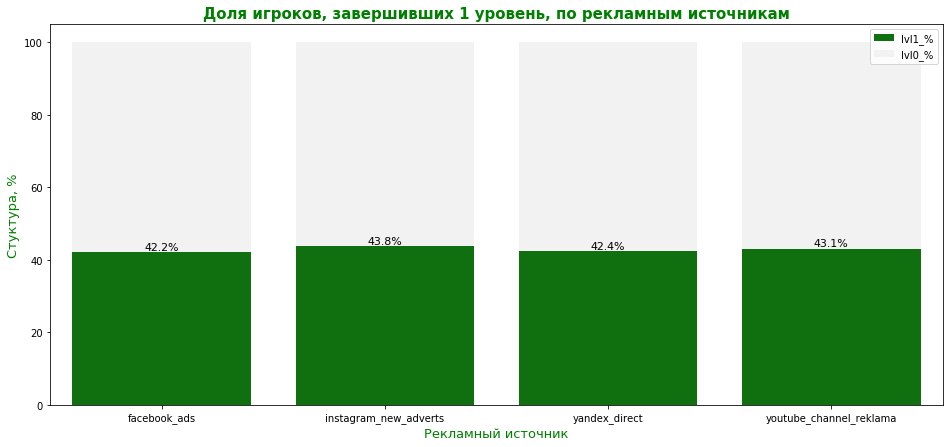

In [45]:
sns_barplot_pct(df,'source', 'lvl1_%', 'lvl0_%', 'Доля игроков, завершивших 1 уровень, по рекламным источникам', 
                'Рекламный источник', 'Стуктура, %', df['lvl1_%'])

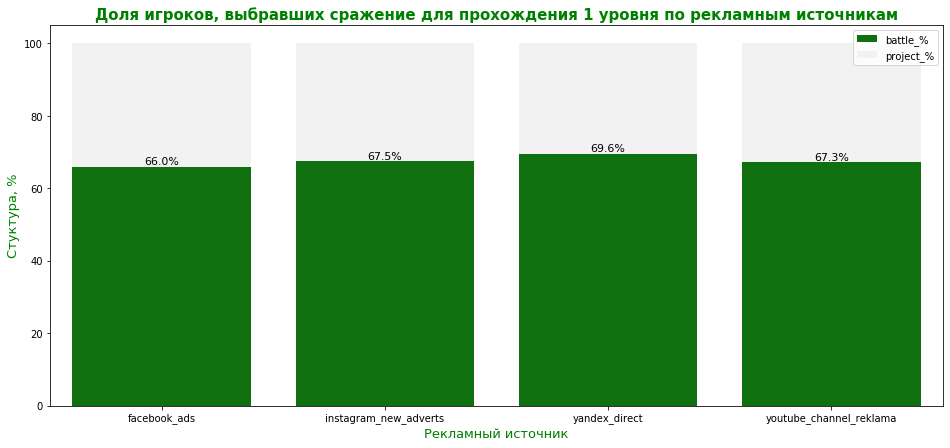

In [46]:
sns_barplot_pct(df,'source', 'battle_%', 'project_%', 
                'Доля игроков, выбравших сражение для прохождения 1 уровня по рекламным источникам', 
                'Рекламный источник', 'Стуктура, %', df['battle_%'])

**Вывод**  
Полученные графики не демонстрируют явных различий в поведении игроков в зависимости от рекламных источников. В среднем около 43% игроков достигли 1 уровня в течение первого месяца, при этом две трети пользователей предпочитают сражения строительству. Однако можно отметить, что пользователи Яндекс.Директ чуть чаще предпочитают сражаться, чем строить, по сравнению с остальными игроками, особенно при сопоставлении с пользователями Фейсбука. Проверим на следующем этапе исследования, является ли разница статистически значимой.

<a name="h4"></a>
### 4. Проверка гипотез

#### Гипотеза 1: существует статистическая значимость различий во времени завершения 1 уровня в зависимости от способа прохождения

*Нулевая гипотеза H₀:* среднее время прохождения 1 уровня через *реализацию проекта* и через *победу над первым игроком* равно.  
*Альтернативная гипотеза H₁:* среднее время прохождения 1 уровня через *реализацию проекта* и через *победу над первым игроком* различается.

Прежде чем мы приступим к тестированию необходимо убедиться, что данные распределены нормально

In [47]:
project = summary[summary['event'] == 'project']
battle = summary[summary['event'] == 'battle']

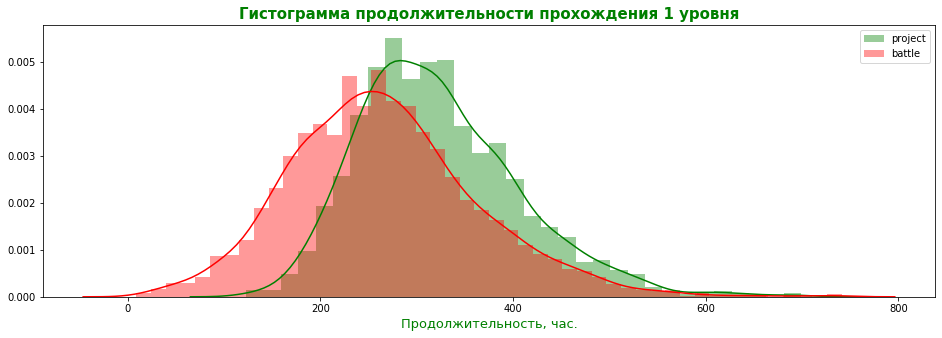

In [48]:
fig, ax = plt.subplots(figsize=(16,5))
sns.distplot(project['lvl1_duration'], hist=True, kde=True, label='project', color = 'green')
sns.distplot(battle['lvl1_duration'], hist=True, kde=True, label='battle', color = 'red')
plt.title('Гистограмма продолжительности прохождения 1 уровня', fontsize = 15, fontweight="bold", color='green')
plt.xlabel("Продолжительность, час.", fontsize = 13, fontweight=500, color='green')
plt.legend();

На гистограме мы видим нормальное распределение, поэтому для тестирования гиоптезы о равенстве средних двух генеральных совокупностей, применим метод scipy.stats.ttest_ind

In [49]:
project_duration = project['lvl1_duration']
battle_duration = battle['lvl1_duration']

alpha = .05

results = st.ttest_ind(project_duration, battle_duration)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

p-значение:  0.000
Отвергаем нулевую гипотезу: разница статистически значима


In [50]:
print('Продолжительность прохождения 1 уровня через реализацию проекта:', 
      '{0:.1f}'.format(project['lvl1_duration'].mean()),'ч.')
print('Продолжительность прохождения 1 уровня через победу над первым игроком:', 
      '{0:.1f}'.format(battle['lvl1_duration'].mean()),'ч.') 

Продолжительность прохождения 1 уровня через реализацию проекта: 322.5 ч.
Продолжительность прохождения 1 уровня через победу над первым игроком: 266.0 ч.


**Вывод**  
Результаты теста Стьюдента говорят о статистической значимости различий во времени прохождения 1 уровня в зависимости от выбранного пути: реализация проекта занимает больше времени, чем победа над игроком (в среднем на 56,5 часов).

#### Гипотеза 2: игроки с Яндекс.Директ чаще предпочитают сражения стройке, чем игроки с Фейсбука

*Нулевая гипотеза H₀:* доли игроков из *Яндекс.Директ* и *Фейсбука*, предпочитающих сражения равны.  
*Альтернативная гипотеза H₁:* доли игроков из *Яндекс.Директ* и *Фейсбука*, предпочитающих сражения различаются.

Воспользуемся z-тестом, который обычно применяют для проверки гипотезы о равенстве долей двух генеральных совокупностей.

В датасет `df` добавим столбец `total_lvl1` с общим количеством игроков, достигнувших 1 уровня по каждому рекламному источнику

In [51]:
df['total_lvl1'] = df['battle']+df['project']
df

event,source,battle,lvl0,project,battle_%,project_%,lvl0_%,lvl1_%,total_lvl1
0,facebook_ads,759,1576,391,66.00,34.00,57.81,42.19,1150
1,instagram_new_adverts,990,1881,476,67.53,32.47,56.20,43.80,1466
2,yandex_direct,1422,2775,620,69.64,30.36,57.61,42.39,2042
3,youtube_channel_reklama,780,1527,379,67.30,32.70,56.85,43.15,1159


In [52]:
alpha = .05

successes = np.array([1422, 759])
trials = np.array([2042, 1150])

# доля "бойцов" из Яндекс.Директ:
p1 = successes[0]/trials[0]

# доля "бойцов" из Фейсбука:
p2 = successes[1]/trials[1]

# доля в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', "{0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

p-значение:  0.034
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод**  
При 5% уровне значимости z-тест подтверждает разницу между предпочтениями игроков с Фейсбука и Яндекса: пользователи из Фейсбука чуть реже выбирают сражения (66% от общего числа пользователей из Фейсбука), чем пользователи Яндекса (70% от общего числа пользователей из Яндекс.Директа). Однако стоит отметить, что при 1% уровне значимости оснований отвергать нулевую гипотезу уже нет (значение p-value составляет 0,034).

<a name="h5"></a>
### 5. Вывод

Мы проанализировали данные о событиях, совершенных в мобильной игре «Космические братья», и получили следующие результаты:

- на рекламу в Яндексе, Фейсбуке и Инстраграме расходуется примерно одинаковое количество денег, в то время как Ютуб обходится в 2 раза дешевле, чем любой другой рекламный источник;
- больше всего денег на рекламу было потрачено 3 мая. В дальнейшем расходы снижались примерно на 40-45% ежедневно относительно прошлого дня;
- самый эффективный рекламный источник - Яндекс.Директ - привлек 35% всех игроков;
- самый дешевый рекламный источник - Ютуб - стоит на 15% дешевле Яндекс.Директа и на на 50% дешевле Фейсбука в пересчете на одного привлеченного игрока;
- в среднем около 43% всех зарегистрированных пользователей завершают 1 уровень. Данный показатель не зависит от вида рекламного источника;
- результаты теста Стьюдента говорят о статистической значимости различий во времени прохождения 1 уровня в зависимости от выбранного пути: реализация проекта занимает больше времени, чем победа над игроком;
- в целом двое из трех игроков предпочитают сражения строительству, однако этот показатель незначительно варьируется в зависимости от источника. Так, при 5% уровне значимости есть основания говорить о значимой разнице по данному показателю между пользователями Фейсбука и Яндекс.Директ, однако уже при 1% уровне, такие основания отсутсвуют (p-value равно 0,034).

Представленной информации недостаточно, чтобы с уверенностью говорить о наличии сильной зависимости поведения игроков от рекламного источника, однако и оснований отвергать такую гипотезу нет. Результаты z-теста при 5% уровне значимости выявляют различия в поведении пользователей. Возможно, анализ более длительного временного промежутка, большего количества событий и действий, совершаемых игроками, позволит выявить новые и более устойчивые закономерности. Чем больше опциональных действий игроков будет предоставлено для анализа, тем эффективнее и надежнее может быть проведено исследование.